In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline  


/Users/chronowanderer/anaconda3/envs/tensorflow/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TIME_STEPS = 8
HIDDEN_UNITS = 32
INPUT_UNITS = 2
OUTPUT_UNITS = 2
BATCH_SIZE = 4
TRAIN_SIZE = 400
EPOCH = 20

DATA_i = 0
DATA_f = 2000


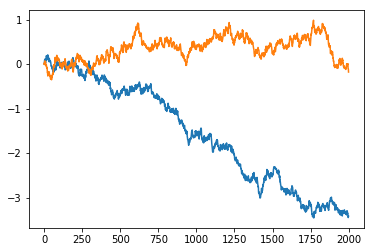

In [3]:
SERIES = 6

path = '/Users/chronowanderer/Desktop/Graduation/Generated_Raw_Data/Result_Seq' + str(SERIES) + '.csv'
f = open(path)   
df = pd.read_csv(f)
dataset = df.iloc[:,1:3].values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.show()

path0 = '/Users/chronowanderer/Desktop/Graduation/Generated_Raw_Data/Resp.csv'
f0 = open(path0)   
df0 = pd.read_csv(f0)
FINALE_TIME = df0.iloc[[SERIES-1],[3]].values
TRAIN_SIZE = int(FINALE_TIME * 0.25)


In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)


In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = TRAIN_SIZE
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# use this function to prepare the train and test datasets for modeling
look_back = TIME_STEPS
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))


In [6]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(HIDDEN_UNITS, input_shape=(look_back, INPUT_UNITS)))
model.add(Dense(OUTPUT_UNITS))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = EPOCH, batch_size = BATCH_SIZE, verbose = 2)


Epoch 1/20
 - 1s - loss: 0.1514
Epoch 2/20
 - 0s - loss: 0.0069
Epoch 3/20
 - 0s - loss: 0.0040
Epoch 4/20
 - 0s - loss: 0.0035
Epoch 5/20
 - 0s - loss: 0.0029
Epoch 6/20
 - 0s - loss: 0.0023
Epoch 7/20
 - 0s - loss: 0.0020
Epoch 8/20
 - 0s - loss: 0.0015
Epoch 9/20
 - 0s - loss: 0.0013
Epoch 10/20
 - 0s - loss: 0.0014
Epoch 11/20
 - 0s - loss: 0.0011
Epoch 12/20
 - 0s - loss: 0.0011
Epoch 13/20
 - 0s - loss: 0.0010
Epoch 14/20
 - 0s - loss: 0.0010
Epoch 15/20
 - 0s - loss: 9.9369e-04
Epoch 16/20
 - 0s - loss: 0.0011
Epoch 17/20
 - 0s - loss: 0.0010
Epoch 18/20
 - 0s - loss: 0.0011
Epoch 19/20
 - 0s - loss: 0.0011
Epoch 20/20
 - 0s - loss: 9.7752e-04


In [7]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 0.06 RMSE
Test Score: 0.38 RMSE


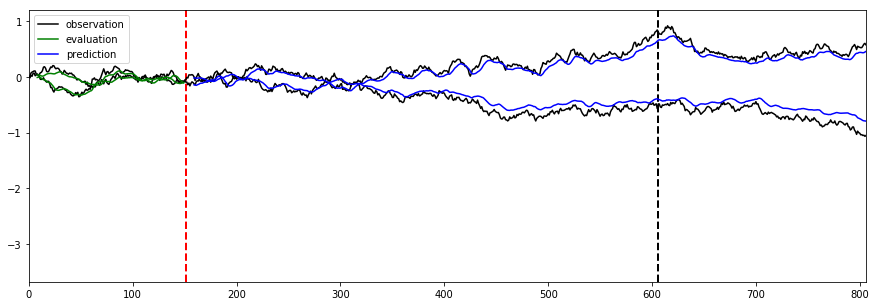

In [8]:
plt.figure(figsize=(15, 5))
plt.xlim(DATA_i, FINALE_TIME + 200)
plt.axvline(train_size, linestyle="dashed", linewidth = 2, color='r')
plt.axvline(FINALE_TIME, linestyle="dashed", linewidth = 2, color='k')

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
observed_lines = plt.plot(scaler.inverse_transform(dataset), label="observation", color="k")
evaluated_lines = plt.plot(trainPredictPlot, label="evaluation", color="g")
predicted_lines = plt.plot(testPredictPlot, label="prediction", color="b")
plt.legend(handles=[observed_lines[0], evaluated_lines[0], predicted_lines[0]],loc="upper left")
plt.show()
